# Проект 3. О вкусной и здоровой пище 
>[DSPR-26] SF TripAdvisor Rating v2.7 Dmitry Lepin

# import

In [4425]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [4426]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [4427]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4428]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4429]:
# Colab
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
population = pd.read_excel('city_population.xlsx')

In [4430]:
# Kaggle
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
# population = pd.read_excel(DATA_DIR+'/city_population.xlsx')

In [4431]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4432]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4433]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [4434]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [4435]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [4436]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [4437]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


# Добавляем файл с численностью населения:
data.City = data.City.str.lower()
data = data.merge(population,on='City', how='left')

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [4438]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,State,population
23646,id_4522,paris,['Moroccan'],4523.0,$$ - $$$,77.0,"[['Sublime couscous !!', 'Lovely restaurant'],...",/Restaurant_Review-g187147-d720153-Reviews-Wal...,d720153,1,4.0,France,2140526
21889,id_477,munich,"['Mediterranean', 'European', 'Spanish', 'Seaf...",481.0,$$ - $$$,119.0,"[['Unacceptable Treatment of Children', 'Great...",/Restaurant_Review-g187309-d742679-Reviews-El_...,d742679,1,4.0,Germany,1484226
41907,id_2406,rome,['Italian'],2407.0,$$ - $$$,87.0,"[[], []]",/Restaurant_Review-g187791-d8693301-Reviews-Le...,d8693301,1,4.5,Italy,2856133
3184,id_3184,rome,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",774.0,$$ - $$$,893.0,"[['Waterfront experience', 'Excellent location...",/Restaurant_Review-g187791-d1641052-Reviews-Cu...,d1641052,0,0.0,Italy,2856133
36205,id_10678,paris,NaN,10680.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d5960726-Reviews-Ba...,d5960726,1,4.0,France,2140526


In [4439]:
data.Reviews[48790]

"[['Satisfied my craving', 'Hawaii in Madrid🍹🍹'], ['08/12/2017', '07/21/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

In [4440]:
#@title FUNCTIONS { run: "auto", form-width: "20%", display-mode: "form" }

def overview_features(df=data):
    '''
    Списки категориальных и числовызх признаков
    '''
    categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
    numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
    print (f'Категориальные: {categorical_columns}')
    print (f'Числовые: {numerical_columns}')


def overview_feature(df, list_feature = [], uniq=5, percent=30):
    '''
    Получаем обзор по всем признакам, либо по списку избранных
    '''
    if len(list_feature) == 0:
        for col in df.columns:
            list_feature.append(col)
    i, all_rows = 0, len(df)
    for col in list_feature:
        s = ''
        s += col
        u = df[col].nunique()
        empty_rows = np.count_nonzero(df[col].isnull())
        p = round(empty_rows/all_rows*100,2)
        # самый частый тип данных в столбце
        top_class = df[col].apply(type).describe().top
        s += ', (' + str(top_class) + ')'

        if (u <= uniq):
            l = pd.unique(df[col].values.ravel())
            s += ', (мало уникальныех) (' + str(u) +')' + str(l)

        if (s != col):
            if p == 0:
                t = 'нет пропусков'
            elif p < percent:
                t = 'пропусков - заполнить'
            else: 
                t = 'пропусков - исключить'
            i += 1
            print(f'{s} {p}% {t}')



def filna_int_feature(df, list_feature = [], method = 'pr'):
    '''
    Заполнить пропуски во всех или в избранных числовых признаках
    method = 'top' - самое частое значение
    method = 'pr' - вероятностное распределение
    '''
    valid_type = ['int',
                  'float',
                  "<class 'pandas._libs.tslibs.timestamps.Timestamp'>"]

    if len(list_feature) == 0:
        return (print('Укажите имя или список имен признаков!'))

    for col in list_feature:
        if df[col].isnull().any():
            s_type = str(df[col].apply(type).describe().top)
            if s_type in valid_type:
                if method == 'top':# самое частое значение
                    df[col].fillna(df[col].value_counts(ascending=False).index[0], inplace=True)
                elif method == 'pr':
                    # маска Series с булевыми значениями - есть или нет пропуски
                    mask = df[col].isna()
                    # статистика распределения значений
                    p = df[col].value_counts() / len(df[col].dropna())
                    # заполняем пропуски с вероятностью `p`
                    df.loc[mask, col] = np.random.choice(p.index.to_list(),
                                                        size=mask.sum(), 
                                                        p=p.to_list())

def column_isnan(df):
    '''
    Проверяем все признаки, если в них есть пустые значения - 
    добавляем признак в датасет
    '''
    for col in df.columns:
        if df[col].isnull().any():
            df[col + '_isNAN'] = pd.isna(df[col]).astype('uint8')
    return (df)

def column_nonunique(df, col_name):
    '''
    Возвращает фрейм всех дубликатов признака, отсортированный по этому признаку
    '''
    mask = df[col_name].duplicated()
    list_nonunique = df[col_name][mask].to_list()
    return (df[df[col_name].isin(list_nonunique)].sort_values(by=[col_name]))


######################### Все про кухни ######################################

def quantity_cuisine(cuisine):
    '''
    Получаем количество кухонь
    '''
    dict_cuisine = {}
    for row in cuisine:
        if pd.notna(row):
            lst = row.split(',') # если не перевели в список раньше
            for l in lst:
                if l in dict_cuisine:
                    dict_cuisine[l] += 1
                else:
                    dict_cuisine[l] = 1
    return (dict_cuisine)


def df_sity_cuisine_qty(data):
    '''
    Получаем датафрейм с количеством ресторанов с кухнями по городам
    и долей кухни всех кухонь ресторанов города
    '''
    groups = data.groupby('City')
    df1 = groups['Cuisine Style'].apply(lambda x: quantity_cuisine(x))
    df1.dropna(inplace=True)
    df1 = df1.reset_index()
    df1.columns = ['City','Cuisine','Quantity']

    df2 = df1.groupby('City')['Quantity'].sum()
    df1 = df1.merge(df2,how='left', on='City')
    df1['weight_Cuisine_city'] = df1['Quantity_x'] / df1['Quantity_y']
    df1 = df1[['Cuisine','City','Quantity_x','weight_Cuisine_city']]
    df1 = df1.rename(columns={'Quantity_x': 'Qty_restorant_Cuisine'})
    return (df1)


def  top_cuisine_cyty(df):
    '''
    Самая распространенная кухня в городе + количество уникальных
    На вход - результат функции df_sity_cuisine_qty
    '''
    groups = df.groupby('City', group_keys=False)
    df1 = groups.apply(lambda x: x[x['Qty_restorant_Cuisine'] == x['Qty_restorant_Cuisine'].max()])
    df2 = groups['Cuisine'].nunique()
    df1 = df1.merge(df2, how='left', on='City')

    df1.reset_index(inplace=True,drop=True)
    df1 = df1.rename(columns={'Cuisine_x': 'top_Cuisine',
                              'Cuisine_y': 'qty_rest_cuisine_city',
                              })
    df1 = df1[['City','top_Cuisine','qty_rest_cuisine_city']]
    return (df1)

def get_dict_weight(row,dt,feature):
    weight = 0
    list_cuisine = row['Cuisine Style'].split(',')
    for l in list_cuisine:
        weight += dt[l][row['City']][feature]
    return (weight)

def get_sum_weight(df,df_dict,feature):
    '''
    Получаем сумму весов кухонь ресторана
    '''
    # Словарь весов кухни по городам 
    dict_change = {n: grp.loc[n].to_dict('index')
    for n, grp in df_dict.set_index(['Cuisine','City']).groupby(level='Cuisine')}
    df['sum_' + feature] = df.apply(lambda x: get_dict_weight(x,dict_change,feature), axis=1)
    return (df)


def top_cuisine_europe(df, top = 0.9000, col_name = 'Cuisine Style'):
    '''
    Более новый вариант - top_group_cuisine
    Если частота повторений кухни среди всех ресторанов Европы меньше заданного % - заменяем
    его на 'col_name + other'
    '''
    other = col_name + ' Europe'

    # cохраняем индексы исходника - пригодятся при merge
    if 'index' in df.columns: # если остался от предыдущих вызовов
        df.drop('index', axis=1, inplace=True)
    df.reset_index(level=0, inplace=True)
    
    df1 = df[['index',col_name]].copy()
    df1.dropna(inplace=True)
    # если кухни еще не в списках, то строки - в списки
    df1[col_name] = df1[col_name].str.split(',')

    # Разворачиваем список вниз - создаём для каждого элемента списка новую строку
    df2 = pd.DataFrame({col:np.repeat(df1[col].values, df1[col_name].str.len())
        for col in df1.columns.drop(col_name)}
        ).assign(**{col_name:np.concatenate(df1[col_name].values)})[df1.columns]

    # Вычисляем долю каждой кухни - сортировка по убыванию доли
    mask = df2[col_name].value_counts(normalize=True,ascending=False).reset_index()
    # оставляем список кухонь для которых накопленная сумма не превышает заданной
    list_sity = mask[mask[col_name].cumsum() <= top]
    list_sity = list_sity['index'].to_list()
    # заменяем на заданный текст те названия, которые не вошли в список 
    df2[other] = df2[col_name].apply(lambda x: x if x in list_sity else other)
  
    # группируем по сохраненному значению индекса, кухни - во множество (чтобы без повторов)
    df1 = df2.groupby('index')[other].apply(set).reset_index()
    # # множество - в строку 
    df1[other] = df1[other].apply(lambda x: ','.join(x))

    # соединяем
    df = df.merge(df1, on=['index'], how='left')
    # заменяем 
    df[col_name] = df[other]
    # подчищаем
    df.drop(['index', other], axis=1, inplace=True)

    return(df)


def top_group_cuisine(df = data, list_col=['City'], top = 0.9000, col_name = 'Cuisine Style'):
    '''
    Возвращает фрейм, в котором непопулярные кухни заменены на общее название.
    Если частота повторений кухни среди всех ресторанов группы (по умолчанию - City,
    но можно пробовать с неограниченным числом признаков)
    меньше заданного % - заменяем его на "col_name + regional"
    '''
    other = col_name + ' regional'
    new_col = col_name + ' ' + ','.join(list_col)
    new_col = new_col.replace(' ','_')

    # cохраняем индексы исходника - пригодятся при merge
    if 'index' in df.columns: # если остался от предыдущих вызовов
        df.drop('index', axis=1, inplace=True)
    df.reset_index(level=0, inplace=True)

    # объединяем списки имен колонок копирования
    listone = ['index', col_name]
    mergedlist = list(set(list_col + listone))

    df1 = df[mergedlist].copy()
    df1.dropna(inplace=True)
    # если кухни еще не в списках, то строки - в списки
    df1[col_name] = df1[col_name].str.split(',')

    # Разворачиваем список вниз - создаём для каждого элемента списка новую строку
    df2 = pd.DataFrame({col:np.repeat(df1[col].values, df1[col_name].str.len())
        for col in df1.columns.drop(col_name)}
        ).assign(**{col_name:np.concatenate(df1[col_name].values)})[df1.columns]

    # список имен колонок для агрегации
    listone = list_col
    listone.append(col_name)

    # # Вычисляем долю каждой кухни - сортировка по убыванию доли
    mask = df2[listone].value_counts(normalize=True,ascending=False).reset_index()
    # оставляем список кухонь для которых накопленная сумма не превышает заданной
    list_sity = mask[mask[0].cumsum() <= top]
    list_sity = list_sity[col_name].to_list()
    # # заменяем на заданный текст те названия, которые не вошли в список 
    df2[new_col] = df2[col_name].apply(lambda x: x if x in list_sity else other)
  
    # # группируем по сохраненному значению индекса, кухни - во множество (чтобы без повторов)
    df1 = df2.groupby('index')[new_col].apply(set).reset_index()
    # # # множество - в строку 
    df1[new_col] = df1[new_col].apply(lambda x: ','.join(x))

    # # соединяем
    df = df.merge(df1, on=['index'], how='left')
    # # заменяем 
    df[col_name] = df[new_col]
    # # подчищаем
    df.drop(['index', new_col], axis=1, inplace=True)

    return(df)


#############################################################################


def code_mean(df, cat_feature, real_feature):
    '''
    Кодируем категориальный признак средним значением для этой категории
    '''
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].mean()))


def get_boxpot(df, list_column, orientation="h"):
    '''
    Рисует ящик с усами
    list_column - список колонок
    orientation="h" - горизонтальная ориентация
    orientation="v" - вертикальная ориентация
    '''
    g = sns.boxplot(data=df[list_column],
                orient=orientation, palette="Set2", whis=1.5);




def get_Ranking_weight_City(row):
    '''
    Вычисляем относительную позицию ресторана среди всех ресторанов города
    '''
    Weighed_Rank = row['Ranking'] / row['Rest_count']

    return Weighed_Rank


def get_Weighed_Rank(row):
    '''
    Относительный вес рейтинга среди ресторанов города
    '''
    i=0
    city_min = CityMinMax[CityMinMax['City'] == row.City ]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax['City'] == row.City ]['max'].iloc[0]
    Weighed_Rank = round(1-(row['Ranking'] - city_min)/(city_max - city_min),3)
    return Weighed_Rank


def filna_cat_int(df, uniq=6, method='moda'):
    '''
    Заменить пропуски в категориальных данных, выраженных числом указанным методом
    method = 'median' - медиана
    method = 'mean' - среднее
    method = 'moda' - самое частое значение
    method = 'pr' - вероятностное распределение
    '''
    for col in df.columns:
        out = len(df[col]) - df[col].count()# количество пустых строк в колонке
        if out > 0:
            u = df[col].nunique()
            # признак номинативных данных 
            if (type(df[col][0]) == str) or (u <= uniq):
                # выражено не строкой
                if df[col].dtypes != object:
                    if method == 'median':
                        df[col].fillna(df[col].median(),inplace=True)
                    elif method == 'mean':
                        df[col].fillna(df[col].mean(),inplace=True)
                    elif method == 'moda':# самое частое значение
                        df[col].fillna(df[col].value_counts(ascending=False).index[0], inplace=True)
                    elif method == 'pr':
                        # маска Series с булевыми значениями - есть или нет пропуски
                        mask = df[col].isna()
                        # статистика распределения значений
                        p = df[col].value_counts() / len(df[col].dropna())
                        # заполняем пропуски с вероятностью `p`
                        df.loc[mask, col] = np.random.choice(p.index.to_list(),
                                                            size=mask.sum(), 
                                                            p=p.to_list())

def get_seaborn_heatmap(data,exclusion_list=[],annot=False):
    '''
    Тепловая карта
    exclusion_list - исключить признаки
    annot - выводить числовые значения на карте
    '''
    corr = data.drop(exclusion_list, axis=1).corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap = "YlGnBu"
    cmap = 'coolwarm'

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, annot=annot,
                cbar_kws={"shrink": .5})


def top_city(df, top = 0.9000):
    '''
    Если доля города в общем количестве городов меньше заданного % - заменяем
    его на "Other"
    '''
    mask = df['City'].value_counts(normalize=True,ascending=False).reset_index()
    list_sity = mask[mask['City'].cumsum() < top]
    list_sity = list_sity['index'].to_list()
    return (df['City'].apply(lambda x: x if x in list_sity else 'Other'))


def get_polynomial_features(df=data, power=2, features=[], norm='std'):
    '''
    Создание полиномиальных признаков
    norm='std' - стандартная нормализация
    norm='minmax' - MinMax нормализация
    norm='' -не проводить нормализацию
    '''
    if len(features) == 0:
        return (print('Укажите имя или список имен признаков!'))
    pf = PolynomialFeatures(power)
    poly_features = pf.fit_transform(df[features])
    poly_features = pd.DataFrame(poly_features)
    poly_features = poly_features.drop(poly_features.columns[[0]], axis=1)

    if norm != '':
        poly_features = get_normalize(poly_features,norm)
        # if poly_features.all() == 0:
        #     return (print('Допустимые значения norm: "std" и "minmax"'))

        # poly_features = pd.DataFrame(poly_features)
        
    col_name = []

    for col in poly_features.columns:
        col_name.append('polynom_' + str(power) + '_' + str(col))

    poly_features.columns = col_name
    df = pd.concat([df,poly_features], sort=False,axis=1)

    return (df)


def get_normalize(df,norm):
    '''
    norm='std' - стандартная нормализация
    norm='minmax' - MinMax нормализация
    '''
    if norm == 'std':
        scaler = StandardScaler()
        arr = scaler.fit_transform(df)
    elif norm == 'minmax':
        scaler = MinMaxScaler()
        arr = scaler.fit_transform(df)
    else:
        print('Допустимые значения norm: "std" и "minmax"')
        return (0)
    df1 = pd.DataFrame(arr)
    return (df1)




# Cleaning and Prepping Data

Рассмотрим отдельно категориальные и числовые данные

In [4441]:
overview_features(data)

Категориальные: ['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'State']
Числовые: ['Ranking', 'Number of Reviews', 'sample', 'Rating', 'population']


In [4442]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print (f'Категориальные: {categorical_columns}')
print (f'Числовые: {numerical_columns}')


Категориальные: ['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'State']
Числовые: ['Ranking', 'Number of Reviews', 'sample', 'Rating', 'population']


In [4443]:
data.info(verbose=True,null_counts =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  State              50000 non-null  object 
 12  population         50000 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 6.6+ MB


In [4444]:
data.describe()

,Ranking,Number of Reviews,sample,Rating,population
count,50000.000000,46800.000000,50000.000000,50000.000000,5.000000e+04
mean,3664.427520,124.471197,0.800000,3.194430,2.775141e+06
std,3700.092452,294.114345,0.400004,1.705453,2.697111e+06
min,1.000000,2.000000,0.000000,0.000000,2.018180e+05
25%,972.000000,9.000000,1.000000,3.000000,9.740730e+05
50%,2278.000000,33.000000,1.000000,4.000000,1.899160e+06
75%,5241.000000,115.000000,1.000000,4.500000,3.348536e+06
max,16444.000000,9660.000000,1.000000,5.000000,8.961989e+06


## Категориальные данные


In [4445]:
# смотрим на признаки, которые можно отнести к категориальным
# Они могут быть в строковом формате или иметь мало уникальных значений.
overview_feature(data,categorical_columns)

Restaurant_id, (<class 'str'>) 0.0% нет пропусков
City, (<class 'str'>) 0.0% нет пропусков
Cuisine Style, (<class 'str'>) 23.18% пропусков - заполнить
Price Range, (<class 'str'>), (мало уникальныех) (3)['$$ - $$$' '$$$$' '$' nan] 34.72% пропусков - исключить
Reviews, (<class 'str'>) 0.0% нет пропусков
URL_TA, (<class 'str'>) 0.0% нет пропусков
ID_TA, (<class 'str'>) 0.0% нет пропусков
State, (<class 'str'>) 0.0% нет пропусков


Признаков не много, можно посмотреть на каждый проблемный отдельно

### Restaurant_id

In [4446]:
data['Restaurant_id'].describe()

count      50000
unique     13094
top       id_227
freq          19
Name: Restaurant_id, dtype: object

Описания этого признака в задании нет. Первоначально предполагалось, что это уникальный номер ресторана и он соответствует индексу датафрейма. Но очевидно, что это не так - уникальных id только 13094 из 50000. Посмотрим на все рестораны одного id. Возможно это сети?

In [4447]:
data[data.Restaurant_id == data['Restaurant_id'].describe().top]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,State,population
227,id_227,madrid,NaN,3208.0,NaN,23.0,"[['40th', 'The Center of Spain'], ['07/23/2017...",/Restaurant_Review-g187514-d10040653-Reviews-P...,d10040653,0,0.0,Spain,3348536
11065,id_227,luxembourg,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",228.0,$$ - $$$,21.0,"[['Nice little Lebanese restaurant', 'Great fo...",/Restaurant_Review-g190356-d10275783-Reviews-K...,d10275783,1,4.0,Luxembourg,633622
14727,id_227,bratislava,"['Healthy', 'European', 'Mediterranean', 'Vege...",228.0,$$ - $$$,122.0,"[['Great fish (African sharptooth catfish)', '...",/Restaurant_Review-g274924-d4009959-Reviews-Me...,d4009959,1,4.0,Slovakia,432864
16237,id_227,athens,"['European', 'Greek', 'Mediterranean']",228.0,$$ - $$$,220.0,"[['Spectacular view and food', 'Great view'], ...",/Restaurant_Review-g189400-d1898490-Reviews-Ol...,d1898490,1,4.5,Greece,664046
17521,id_227,warsaw,"['Polish', 'European', 'Central European', 'Ea...",228.0,$$ - $$$,95.0,"[['Great place', 'A lovely warm place and good...",/Restaurant_Review-g274856-d2410632-Reviews-Fe...,d2410632,1,4.0,Poland,1793579
19299,id_227,amsterdam,"['Dutch', 'Bar', 'European', 'Gastropub', 'Caf...",228.0,$$ - $$$,201.0,"[['Historic jewel of a bar in Amsterdam', 'Gre...",/Restaurant_Review-g188590-d753101-Reviews-Pro...,d753101,1,4.5,Netherlands,873289
22537,id_227,madrid,"['Bar', 'Mediterranean', 'Spanish', 'Vegetaria...",228.0,$$ - $$$,1011.0,"[['Dinner', 'Old traditional Spanish restauran...",/Restaurant_Review-g187514-d697471-Reviews-Cas...,d697471,1,4.0,Spain,3348536
23876,id_227,rome,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",228.0,$$ - $$$,1066.0,"[['Great start to Italian food journey', 'My F...",/Restaurant_Review-g187791-d1516161-Reviews-Go...,d1516161,1,4.5,Italy,2856133
24990,id_227,dublin,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",228.0,$$ - $$$,119.0,"[['Fantastic with young people', 'Italian Scho...",/Restaurant_Review-g186605-d10516461-Reviews-P...,d10516461,1,4.5,Ireland,554554
27610,id_227,ljubljana,"['Pizza', 'European', 'Slovenian']",228.0,$$ - $$$,78.0,"[['Good beer', 'OK if you choose correctly'], ...",/Restaurant_Review-g274873-d3292800-Reviews-Kr...,d3292800,1,3.5,Slovenia,295504


Это точно не сетевые рестораны (разные кухни и ценовые ранги) и не id ресторана в стране (в одной стране - несколько одинаковых id). Скорее всего это уникальные id для города. Проверим:

In [4448]:
# сумма уникальных id по каждому городу равна общему числу уникальных id
len(data.groupby('Restaurant_id')['City'].nunique()) == data['Restaurant_id'].nunique()

True

* `Restaurant_id` оставить для обработки

### URL_TA
url ресторана - должны быть уникальны

In [4449]:
data['URL_TA'].describe()

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d2669414-Reviews-Vi...
freq                                                      2
Name: URL_TA, dtype: object

Тоже немного необычный результат - оказывается не все url`ы одинаковы... 37 не уникальных значений.Посмотрим на них...


In [4450]:
# Все неуникальные строки URL_TA, отсортированы по URL_TA
column_nonunique(data,'URL_TA')

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,State,population
23980,id_3239,madrid,NaN,3241.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0,Spain,3348536
48946,id_3242,madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0,Spain,3348536
28388,id_1229,madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,4.0,Spain,3348536
4534,id_4534,madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,0,0.0,Spain,3348536
23576,id_1277,madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1279.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,1,4.0,Spain,3348536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32998,id_2312,madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,$$ - $$$,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900,1,4.0,Spain,3348536
36920,id_1800,warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,1,3.5,Poland,1793579
118,id_118,warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,0.0,Poland,1793579
15544,id_1980,warsaw,"['Mediterranean', 'Middle Eastern', 'Italian',...",1981.0,$$ - $$$,16.0,"[['Good restaurant for one meal.', 'Olive Gard...",/Restaurant_Review-g274856-d3396817-Reviews-Re...,d3396817,1,4.0,Poland,1793579


* Все дублирующиеся `url` имеют одинаковые `ID_TA`, но разные `Restaurant_id`
* При этом в раммках одного дубликата url могут быть как одинаковы, так и различаться такие параметры - `Ranking`, `sample`(то есть одна строка в тренировочной выборке, а другая в тестовой), `Number of Reviews`(в одном случае)
* Почему-то такое дублирование затронуло в основном рестораны Мадрида и 2 ресторана Варшавы...

In [4451]:
# кол-во уникальных Restaurant_id
column_nonunique(data,'URL_TA')['Restaurant_id'].nunique()

74

In [4452]:
# кол-во уникальных ID_TA
column_nonunique(data,'URL_TA')['ID_TA'].nunique()

37

### ID_TA

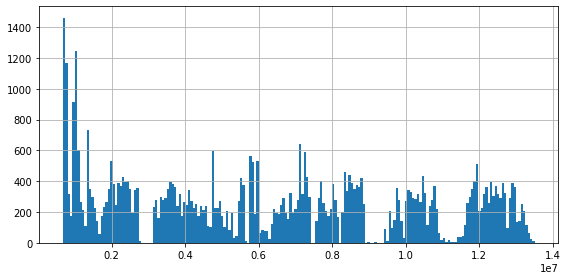

In [4453]:
# id должны содержать числовую часть, которая должна образовываться накоплением
# Посмотрим на признак, как на числа
data['ID_TA'].apply(lambda x: x.replace('d','')).astype(int).hist(figsize=(8, 4), bins=200);
plt.tight_layout()

Не очень похоже на id - данные складываются в некие группы...

In [4454]:
data['ID_TA'].describe()

count         50000
unique        49963
top       d11674463
freq              2
Name: ID_TA, dtype: object

Точно такая же ситуация, как и с признаком `URL_TA` - дублированны 37 записей, но не полностью...

Возможно это ошибки из-за слияния разных версий датафреймов в прошлом...
В любом случае - эти признаки будут исключены

In [4455]:
# Удаляем 2 признака
data.drop(['URL_TA','ID_TA'], axis=1, inplace=True)

### City

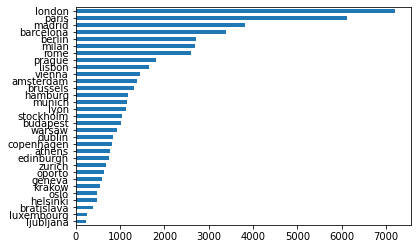

In [4456]:
# В оригинальном фрейме города распределены не равномерно, для достижения большей
# точности модели - будем заменять название города на "Other" если его доля меньше заданной
# требуется перезапуск всего кода.

# !!!!
# На этапе Data Preprocessing - функция 'top_city' ингда вызыает ошибку (не пофиксил!). 
# В любом случае - эксперименты показали, что использование порога меньше 1 - ухудшает модель
# Лучше не использовать => закомментил её
# задаём порог в % от 0 до 1
# data['City'] = top_city(df = data,top=1) 
data['City'].value_counts(ascending=True).plot(kind='barh');

In [4457]:
data['City'].describe()

count      50000
unique        31
top       london
freq        7193
Name: City, dtype: object

* нет пропусков данных
* Лондон и Париж ушли в отрыв
* Оставляем 

### Cuisine Style

In [4458]:
# Посмотрим на заполненность в целом
display(data['Cuisine Style'].describe())

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object

In [4459]:
display(data['Cuisine Style'])

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [4460]:
# очистить строки от лишних символов, в нижний регистр
data['Cuisine Style'] = data['Cuisine Style'].replace('[^a-zA-Z, ]', '', regex=True).str.lower()
data['Cuisine Style'] = data['Cuisine Style'].replace(', ', ',', regex=True)

In [4461]:
overview_feature(data,['Cuisine Style'])

Cuisine Style, (<class 'str'>) 23.18% пропусков - заполнить


* Есть пропуски в виде nan
* Оставляем для обработки

### Price Range

In [4462]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [4463]:
overview_feature(data,['Price Range'])

Price Range, (<class 'str'>), (мало уникальныех) (3)['$$ - $$$' '$$$$' '$' nan] 34.72% пропусков - исключить


По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

В этих данных 34.72% - пропуски. Принято счититать, что если пропущено более 30% данных, то их лучше исключить из датасета. Однако в данном случае отсутствие данных скорее всего говорит не об ошибке, а о том, что ресторан еще не был оценен, что также несет определенную информацию.
* Кодируем признаки

In [4464]:
# Сохраним данные о пропусках в 'Price Range' в отдельном признаке 
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
# кодируем и заполняем nan 0-ми
dict_change = {'$': 1,'$$ - $$$': 2,'$$$$':3}
data['Price Range'] = data['Price Range'].map(dict_change)

In [4465]:
data['Price Range'].value_counts()

2.0    23041
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

In [4466]:
overview_feature(data,['Price Range'])

Price Range, (<class 'float'>), (мало уникальныех) (3)[ 2.  3.  1. nan] 34.72% пропусков - исключить


* оставляем для обработки

### Reviews
Отзывы и даты отзывов

In [4467]:
# Будем сравнивать результаты обработки с исходниками строк
for i in [28330, 48790, 28331, 49971, 49935, 38330, 49811, 49019, 1158, 49859, 49885]:
    print(i, data.Reviews[i])

28330 [['An asset to the neighbourhood'], ['10/08/2015']]
48790 [['Satisfied my craving', 'Hawaii in Madrid🍹🍹'], ['08/12/2017', '07/21/2017']]
28331 [['Enjoyable meal', '"Tasty pizzas"'], ['10/22/2017', '02/26/2017']]
49971 [['Rest your eyes, enjoy a light meal!', 'Nothing special'], ['07/10/2017', '07/05/2017']]
49935 [[], []]
38330 [['Good food, attentive staff', 'Sternstraße 125, Schanzenviertel, [59], ju...'], ['05/10/2015', '07/05/2014']]
49811 [['Good food, nice service, incredibly thrash...', "'90 in all the aspects"], ['10/02/2017', '10/16/2017']]
49019 [['Nice bakery!', '😙💨🎂 CVKE 😚🍰'], ['11/29/2017', '02/08/2015']]
1158 [['NYE', 'Good food, not as expensive as mentioned'], ['01/04/2018', '01/04/2018']]
49859 [['Ben', 'Fine food if you have the taste'], ['12/20/2017', '11/21/2017']]
49885 [["Viva Marina's", 'Fabulous hidden gem in Barcelona'], ['07/07/2014', '06/28/2014']]


* Признак предствлен в виде списка со вложенными списками в формате строки - то есть обработать его методами списков напрямую невозможно. 
* В строке в первом списке содержатся 1-2 отзыва, разделенные запятыми (внутри отзыва так же могут быть запятые, поэтому разделить отзывы по этому разделителю корректно - затруднительно)
* Во втором вложенном списке - 1-2 даты, соответствующие отзывам. Даты в  формате `mm/dd/yyyy`
* Каждый отзыв заключен в одинарные кавычки
* Внутри отзыва встречаются двойные кавычки, объекты в квадратных скобках

План обработки
1. Разделить строку на 2 части (отзывы и даты) по разделителю "], ["
2. Каждую полученную строку разделить еще раз по второму вхождению одинарной кавычки.
3. В результате должны получить 4 серии очищенных данных - 2 серии с отзывами и 2 серии с датами

In [4468]:
# Делим на столбец отзывов и столбец дат, сразу в нижний регистр
df_rev = data.Reviews.str.split('\], \[', expand=True)
df_rev.columns = ['comment','dates']
df_rev.comment = df_rev.comment.str.lower()

In [4469]:
df_rev.sample(5)

,comment,dates
45925,"[['old school restaurant', 'super klopa'","'11/02/2017', '10/19/2017']]"
14997,"[['a lunch time snack', 'addicted!!'","'02/05/2017', '11/27/2016']]"
39917,"[['oh god, that portion!', 'best falafel in uk!'","'05/03/2017', '03/31/2017']]"
359,"[['lovely food and attentive service', 'a gem ...","'05/14/2017', '11/01/2017']]"
2882,"[['ingredients are fresh.', 'focus on fresh fo...","'11/06/2015', '07/05/2015']]"


#### Комментарии

In [4470]:
# Комментарии
df_comment = df_rev.comment.str.split(pat=", '", n=1, expand=True)
df_comment = df_comment.replace('[^\w\s]', '', regex=True)
df_comment.columns = ['comment_1','comment_2']
# Замена пробелов и None на nan
df_comment = df_comment.replace(r'^\s*$', np.nan, regex=True)
df_comment = df_comment.fillna(value=np.nan)

In [4471]:
df_comment.describe()

,comment_1,comment_2
count,41873,35399
unique,33120,27759
top,excellent,excellent
freq,208,172


#### Даты

In [4472]:
# Даты
df_dates = df_rev.dates.str.split(pat="',", n=1, expand=True)
df_dates = df_dates.replace('[^\d/]', '', regex=True)
df_dates.columns = ['date_1','date_2']
# в формат дат
df_dates['date_1'] = pd.to_datetime(df_dates.date_1)
df_dates['date_2'] = pd.to_datetime(df_dates.date_2)
# Соединим с основным датафреймом
data = pd.concat([data,df_comment,df_dates], sort=False,axis=1)
# Исходный Reviews можно удалить
data.drop(['Reviews'], inplace=True, axis=1)

## Числовые признаки

In [4473]:
overview_feature(data,numerical_columns)

Ranking, (<class 'float'>) 0.0% нет пропусков
Number of Reviews, (<class 'float'>) 6.4% пропусков - заполнить
sample, (<class 'int'>), (мало уникальныех) (2)[0 1] 0.0% нет пропусков
Rating, (<class 'float'>) 0.0% нет пропусков
population, (<class 'int'>) 0.0% нет пропусков


`sample` и `population` - добавлены вручную

In [4474]:
data[numerical_columns].describe()

,Ranking,Number of Reviews,sample,Rating,population
count,50000.000000,46800.000000,50000.000000,50000.000000,5.000000e+04
mean,3664.427520,124.471197,0.800000,3.194430,2.775141e+06
std,3700.092452,294.114345,0.400004,1.705453,2.697111e+06
min,1.000000,2.000000,0.000000,0.000000,2.018180e+05
25%,972.000000,9.000000,1.000000,3.000000,9.740730e+05
50%,2278.000000,33.000000,1.000000,4.000000,1.899160e+06
75%,5241.000000,115.000000,1.000000,4.500000,3.348536e+06
max,16444.000000,9660.000000,1.000000,5.000000,8.961989e+06


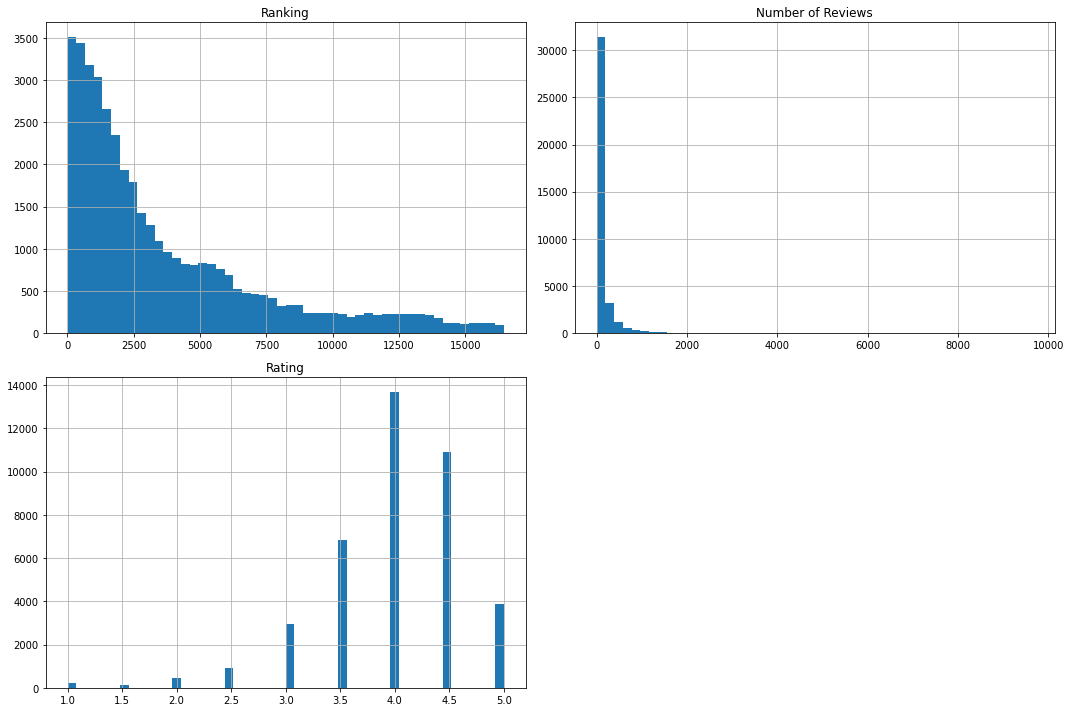

In [4475]:
df_train[['Ranking','Number of Reviews','Rating']].hist(figsize=(15, 10), bins=50);
plt.tight_layout()

1. `Number of Reviews`
    * Есть пропуски
    * Значительное количество ресторанов с минимальным числом отзывов - среднее существенно больше медианы
    * Оставляем для исследования

2. `Ranking`
    * Нет пропусков
    * Данные выглядят нормально
    * Оставляем для исследования
3. `Rating`
    * Целевая переменная
    * Нет пропусков

In [4476]:
data.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,State,population,Price Range_isNAN,comment_1,comment_2,date_1,date_2
27541,id_12237,paris,"italian,french,american,indian,vegetarian frie...",12239.0,NaN,3.0,1,3.5,France,2140526,1,NaN,NaN,NaT,NaT
35354,id_1418,milan,"italian,pizza,seafood,mediterranean,vegetarian...",1420.0,2.0,384.0,1,3.5,Italy,1404239,0,pasta is pasta,very tasty pizza very economical price,2017-12-31,2017-11-30


# 2. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [4477]:
# Проверим функцией - если остались признаки с nan, которые не были добавлены - создаём их
data = column_isnan(data)

In [4478]:
# Какие остались признаки с nan?
data.isnull().any()[lambda x: x == True]

Cuisine Style        True
Price Range          True
Number of Reviews    True
comment_1            True
comment_2            True
date_1               True
date_2               True
dtype: bool

### Price Range

In [4479]:
# замена на 0
# data['Price Range'].fillna(0, inplace=True)

# замена на медиану
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)

# замена на среднее
# data['Price Range'].fillna(data['Price Range'].mean(), inplace=True)

### Cuisine Style
* Можно определить наиболее типичную кухню (кухни) для города и заполнить этими данными пропуски
* Или можно заполнить пропуски значением "Unknown", что тоже не лишено логики (более простой вариант) (пока не реализовано)

До замены пропусков можно вычислить наименее распространенные кухни и объединить их в отдельную группу - это должно улучшить точность модели.

In [4480]:
# Смотрим на частоту "встречаемости" кухни. По умолчанию - в городе. Если она не входит в N - 
# заменяем на общее название "Cuisine Style regional"
# Перезапускать со всем кодом!
N = .50
data = top_group_cuisine(df = data, top = N, list_col=['City'])

In [4481]:
# То же самое - но без группировки по городу
# N - доля наиболее часто встречающихся, остальные - в группу "Cuisine Style Europe"
# N = .90
# data = top_cuisine_europe(data, N)

Создадим 2 вспомогательных фрейма:
* `df_cuisine` - развернём вниз все имеющиеся кухни в каждом городе, для каждого сочетания город-кухня вычислим количество ресторанов с этой кухней в этом городе, и долю этой кухни города в числе всех кухонь города
* `df_top` - для каждого города найдём самую распространенную кухню и количество уникальных кухонь в городе

In [4482]:
df_cuisine = df_sity_cuisine_qty(data)
df_top = top_cuisine_cyty(df_cuisine)

In [4483]:
display(df_cuisine.sample(),df_top.sample())

,Cuisine,City,Qty_restorant_Cuisine,weight_Cuisine_city
628,spanish,munich,22.0,0.009283


,City,top_Cuisine,qty_rest_cuisine_city
22,oporto,portuguese,23


In [4484]:
df_top

,City,top_Cuisine,qty_rest_cuisine_city
0,amsterdam,european,30
1,athens,greek,28
2,barcelona,spanish,31
3,berlin,vegetarian friendly,30
4,bratislava,Cuisine Style regional,29
5,brussels,european,29
6,budapest,european,31
7,copenhagen,Cuisine Style regional,30
8,dublin,vegetarian friendly,29
9,edinburgh,vegetarian friendly,29


In [4485]:
data['Cuisine Style'].describe()

count                      38410
unique                      4398
top       Cuisine Style regional
freq                        2007
Name: Cuisine Style, dtype: object

In [4486]:
# data['Cuisine Style'].value_counts(ascending=True).plot(kind='barh');

In [4487]:
# Заменим пропуски самой популярной кухней города 
data = data.merge(df_top, on='City', how='left')

In [4488]:

data['Cuisine Style'] = np.where(data['Cuisine Style'].isna(),data['top_Cuisine'],data['Cuisine Style'])

In [4489]:
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,State,population,Price Range_isNAN,comment_1,comment_2,date_1,date_2,Cuisine Style_isNAN,Number of Reviews_isNAN,comment_1_isNAN,comment_2_isNAN,date_1_isNAN,date_2_isNAN,top_Cuisine,qty_rest_cuisine_city
14040,id_12281,london,"japanese,fast food,asian",12291.0,1.0,23.0,1,3.5,England,8961989,0,good cheap food,ramen vs bibimbap very good and very bad,2017-11-13,2017-04-03,0,0,0,0,0,0,vegetarian friendly,32
7071,id_7071,paris,french,11792.0,2.0,5.0,0,0.0,France,2140526,1,NaN,NaN,NaT,NaT,0,0,1,1,1,1,french,31
36421,id_1349,zurich,Cuisine Style regional,1354.0,2.0,3.0,1,3.5,Switzerland,415215,1,nice corner café for drinks,lovely decoration and beautiful coffee,2017-03-18,2017-03-04,1,0,0,0,0,0,Cuisine Style regional,30


### Number of Reviews
* Отсутствие отзыва - это скорее всего не ошибка в данных, а объективная реальность, поэтому логично заменить nan на "0".

* Но возможно поэкспериментировать - заменить средним или медианой по группе (например по городу или стране)


In [4490]:
# ВАРИАНТ 1 - замена на 0
data['Number of Reviews'].fillna(0, inplace=True)

In [4491]:
# ВАРИАНТ 2 - замена медианным значением для группы - город
# x = data.groupby('City')['Number of Reviews'].transform('median')
# data['Number of Reviews'].fillna(x,inplace=True)

In [4492]:
# ВАРИАНТ 3 - замена средним значением для группы - город
# x = data.groupby('City')['Number of Reviews'].transform('mean')
# data['Number of Reviews'].fillna(x,inplace=True)

### Даты


In [4493]:
overview_feature(data,['date_1','date_2'])

date_1, (<class 'pandas._libs.tslibs.timestamps.Timestamp'>) 16.23% пропусков - заполнить
date_2, (<class 'pandas._libs.tslibs.timestamps.Timestamp'>) 27.59% пропусков - заполнить


Чтобы понять каким образом лучше заполнить пропуски в датах, нужно понимать как они распределены.

Для удобства создадим для первой и второй даты новый признак - день недели и посмотрим на его распределение.

* Есть пропуски в датах
* Посмотрим на дни недели
* Необходимо перевести даты в числовое значение, при этом сохранив логику - чем более ранний по времени отзыв, тем он имеет меньшее значение для предсказания рейтинга в настоящем и будущем.
* Преобразуем каждую серию дат в разницу в днях между датой в текущей строке и самой ранней датой в серии. 
* Затем заменим пропуски на "0"
* Применим для дат МинМакс нормализацию

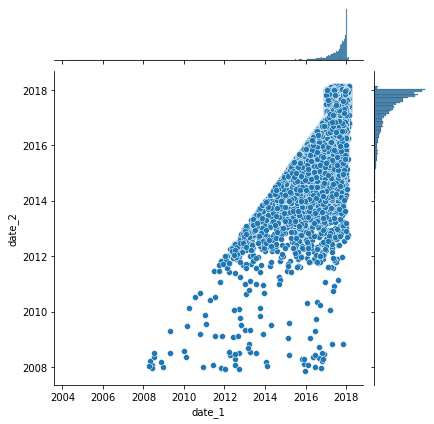

In [4494]:
sns.jointplot(data=data, x="date_1", y="date_2");

In [4495]:
#@title Варианты замены NaT в датах { form-width: "30%" }
variable_date = "\u0421\u043B\u0443\u0447\u0430\u0439\u043D\u0430\u044F \u0434\u0430\u0442\u0430" #@param ["\u0421\u043B\u0443\u0447\u0430\u0439\u043D\u0430\u044F \u0434\u0430\u0442\u0430", "\u0421\u0430\u043C\u0430\u044F \u0447\u0430\u0441\u0442\u0430\u044F", "\u0421\u0432\u0435\u0440\u0445\u0443-\u0412\u043D\u0438\u0437-\u0412\u0432\u0435\u0440\u0445"]
l = ['date_1','date_2']
if variable_date == 'Случайная дата':
    filna_int_feature(data, l,'pr')
elif variable_date == 'Самая частая':
    filna_int_feature(data, l,'top')
elif variable_date == 'Сверху-Вниз-Вверх':
    data.fillna(method='ffill',inplace=True)
    data.fillna(method='backfill',inplace=True)

# в формат дат
data['date_1'] = pd.to_datetime(data.date_1)
data['date_2'] = pd.to_datetime(data.date_2)

## ИТОГИ

In [4496]:
# Какие остались признаки с nan?
data.isnull().any()[lambda x: x == True]

comment_1    True
comment_2    True
dtype: bool

In [4497]:
# Удаляем то, что не будем использовать
data.drop(['comment_1','comment_2'], axis=1, inplace=True)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных)
>Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Ranking - признак
Посмотрим распределение признака

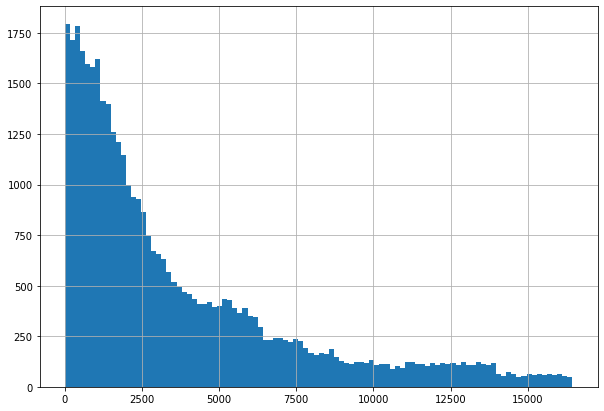

In [4498]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100);

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

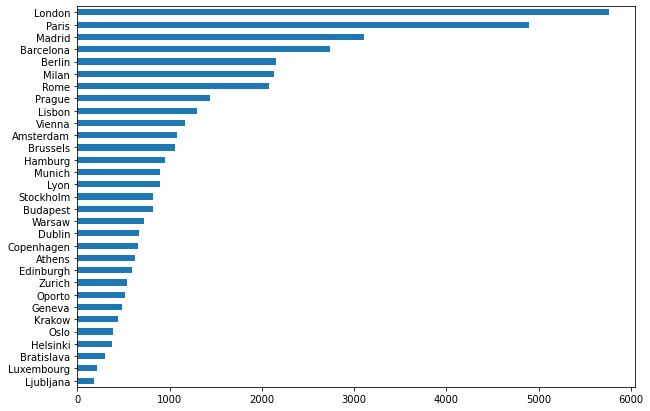

In [4499]:
df_train['City'].value_counts(ascending=True).plot(kind='barh');

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

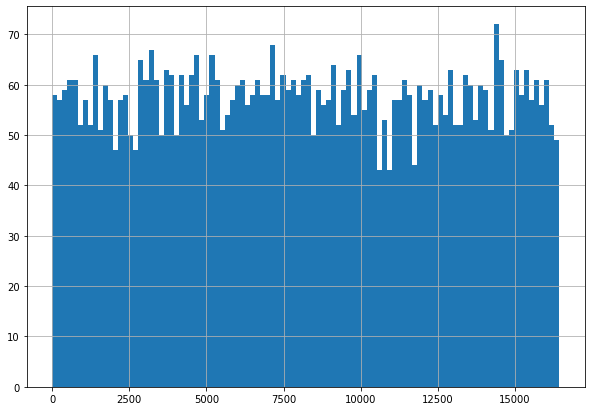

In [4500]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100);

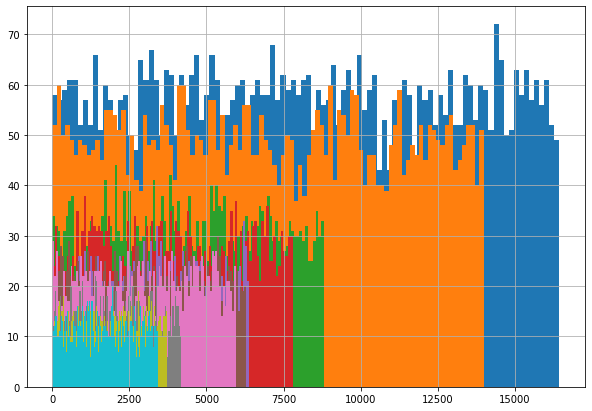

In [4501]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Rating - целевая переменная
Посмотрим распределение целевой переменной

/usr/local/lib/python3.7/dist-packages/IPython/core/displayhook.py:260: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


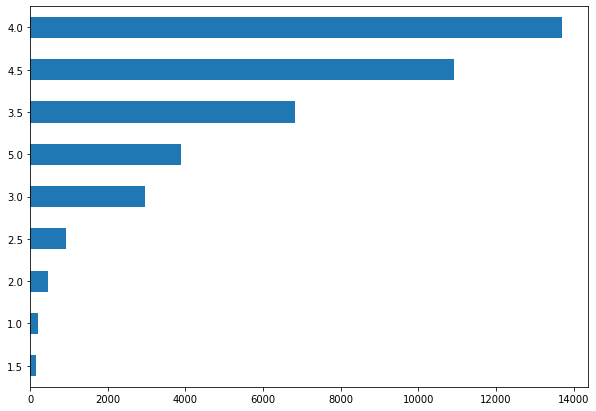

In [4502]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Ranking - Rating
Посмотрим распределение целевой переменной относительно признака

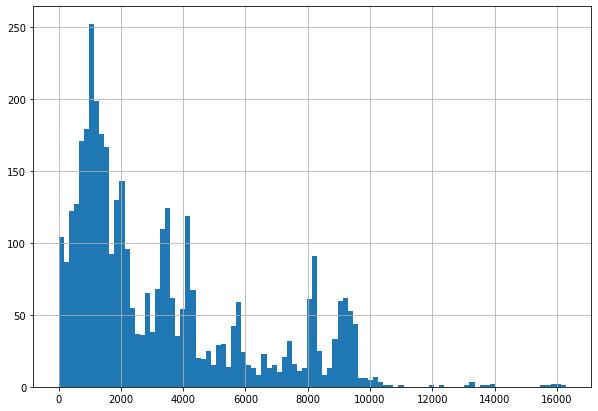

In [4503]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

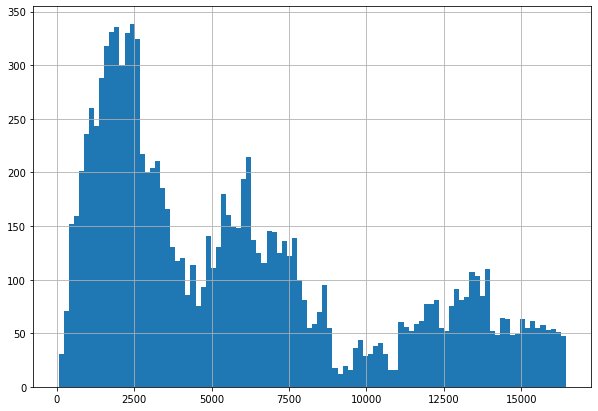

In [4504]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Ranking - Number of Reviews

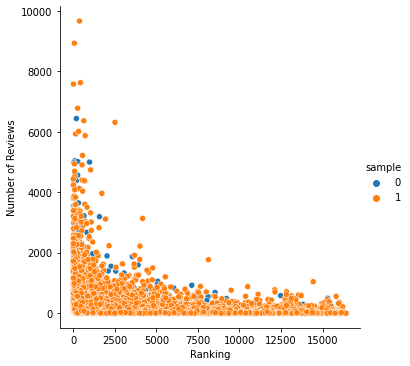

In [4505]:
# Есть ли взаимосвязь рейтинга ресторана в городе и количеством отзывов?
sns.relplot(x="Ranking", y="Number of Reviews", hue="sample", data=data);

Оказывается нет линейной зависимости рейтинга и количества отзывов, хотя некоторая тенденция в этом направлении видна.

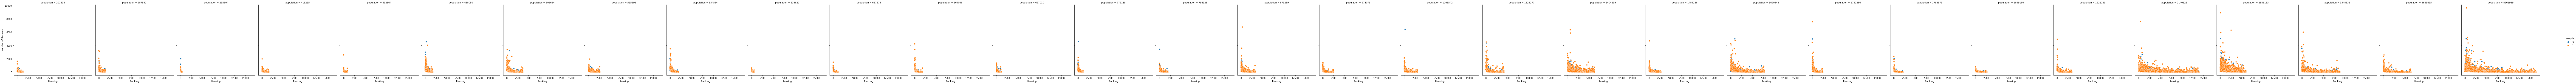

In [4506]:
# Добавим к этим переменным  численность населения

sns.relplot(x="Ranking", y="Number of Reviews", hue="sample",
            col="population", data=data);

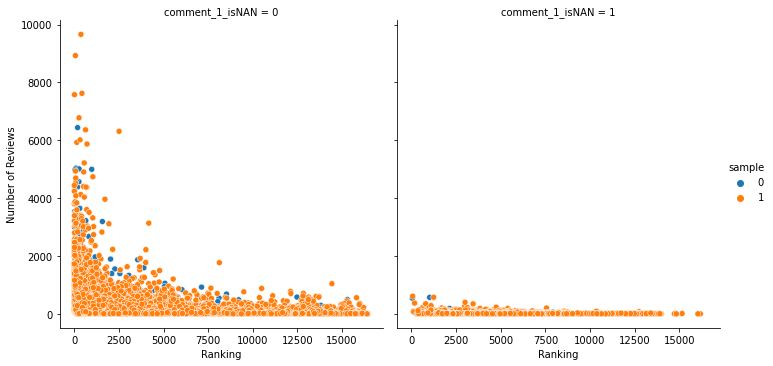

In [4507]:
# Добавим к этим переменным - есть или нет комментарии?
sns.relplot(x="Ranking", y="Number of Reviews", hue="sample",
            col="comment_1_isNAN", data=data);

Оказывается есть рестораны с высоким рейтингом, но без отзывов и без коментариев

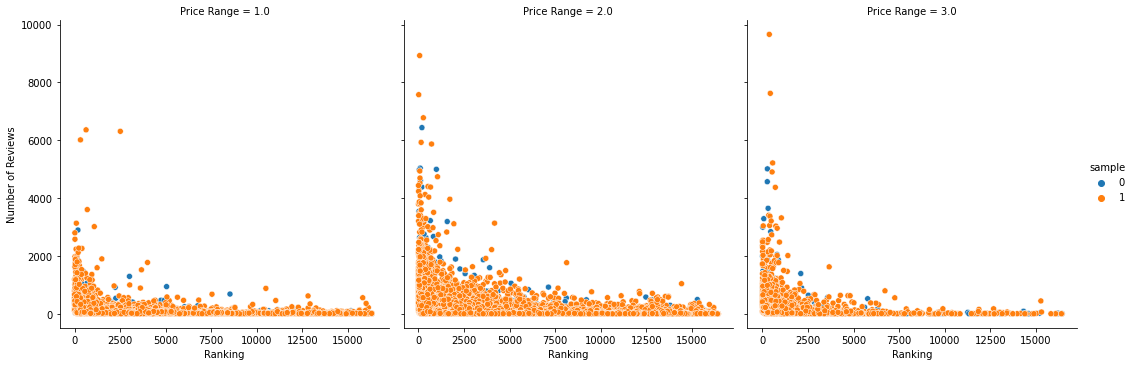

In [4508]:

sns.relplot(x="Ranking", y="Number of Reviews", hue="sample",
            col="Price Range", data=data);

In [4509]:
overview_feature(data)

Restaurant_id, (<class 'str'>) 0.0% нет пропусков
City, (<class 'str'>) 0.0% нет пропусков
Cuisine Style, (<class 'str'>) 0.0% нет пропусков
Ranking, (<class 'float'>) 0.0% нет пропусков
Price Range, (<class 'float'>), (мало уникальныех) (3)[2. 3. 1.] 0.0% нет пропусков
Number of Reviews, (<class 'float'>) 0.0% нет пропусков
sample, (<class 'int'>), (мало уникальныех) (2)[0 1] 0.0% нет пропусков
Rating, (<class 'float'>) 0.0% нет пропусков
State, (<class 'str'>) 0.0% нет пропусков
population, (<class 'int'>) 0.0% нет пропусков
Price Range_isNAN, (<class 'int'>), (мало уникальныех) (2)[0 1] 0.0% нет пропусков
date_1, (<class 'pandas._libs.tslibs.timestamps.Timestamp'>) 0.0% нет пропусков
date_2, (<class 'pandas._libs.tslibs.timestamps.Timestamp'>) 0.0% нет пропусков
Cuisine Style_isNAN, (<class 'int'>), (мало уникальныех) (2)[0 1] 0.0% нет пропусков
Number of Reviews_isNAN, (<class 'int'>), (мало уникальныех) (2)[0 1] 0.0% нет пропусков
comment_1_isNAN, (<class 'int'>), (мало уникальные

### Корреляция
И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

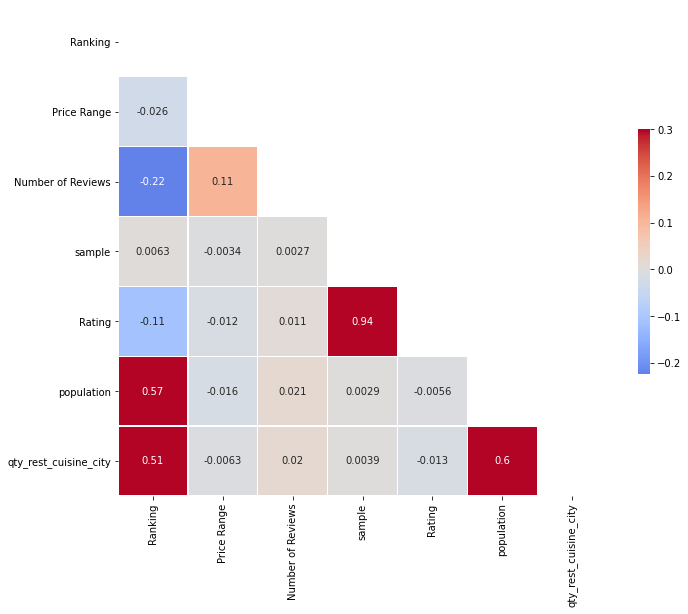

In [4510]:
list_column  = [x for x in data.columns if x.find('isNAN')>0]
get_seaborn_heatmap(data,list_column,annot=True)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# 3. Обработка признаков и Feature Engineering

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

### В рукопашную

#### Даты

>Можно добавить:
* Дни недели (номера дней)
* Является ли этот день выходным (1,0)
* Год
* Месяц
* День (число)
* Разницу в днях между текущей и самой ранней датой в серии (чем ближе дата к настоящему времени, тем весомей)
* Разницу в днях можно нормализовать (МинМакс)

In [4511]:
# Эксперименты показали, что все это плохо влияет на точность модели

# Дни недели
data['date_1_day_of_week'] = data['date_1'].dt.dayofweek
data['date_2_day_of_week'] = data['date_2'].dt.dayofweek
# Год
data['date_1_year'] = data['date_1'].dt.year
data['date_2_year'] = data['date_2'].dt.year
# Месяц
data['date_1_month'] = data['date_1'].dt.month
data['date_2_month'] = data['date_2'].dt.month
# День
data['date_1_day'] = data['date_1'].dt.day
data['date_2_day'] = data['date_2'].dt.day
# Выходные
data['date_1_weekend'] = np.where(data['date_1_day_of_week'] > 4, 1, 0)
data['date_2_weekend'] = np.where(data['date_2_day_of_week'] > 4, 1, 0)
# # Заполняем величиной разницы в днях
# data['date_1'] = (data['date_1'] - data['date_1'].min()).dt.days
# data['date_2'] = (data['date_2'] - data['date_2'].min()).dt.days

### Нормализация дат

In [4512]:
df_dates = data[['date_1','date_2']].copy()
df_dates = get_normalize(df_dates,'std')
df_dates.columns = ['norm_date_1','norm_date_2']
data = pd.concat([data,df_dates], sort=False,axis=1) # Соединяем с основным фреймом

In [4513]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,State,population,Price Range_isNAN,date_1,date_2,Cuisine Style_isNAN,Number of Reviews_isNAN,comment_1_isNAN,comment_2_isNAN,date_1_isNAN,date_2_isNAN,top_Cuisine,qty_rest_cuisine_city,date_1_day_of_week,date_2_day_of_week,date_1_year,date_2_year,date_1_month,date_2_month,date_1_day,date_2_day,date_1_weekend,date_2_weekend,norm_date_1,norm_date_2
35061,id_7058,barcelona,"fast food,european",7059.0,1.0,101.0,1,3.0,Spain,1620343,0,2017-07-24,2016-09-30,0,0,0,0,0,0,spanish,31,0,4,2017,2016,7,9,24,30,0,0,0.224651,-0.364380
2916,id_2916,madrid,pizza,8366.0,2.0,6.0,0,0.0,Spain,3348536,1,2017-02-27,2018-01-07,0,0,1,1,1,1,spanish,31,0,6,2017,2018,2,1,27,7,0,1,-0.180730,0.796952
35871,id_53,edinburgh,"vegetarian friendly,gluten free options,europe...",54.0,3.0,1880.0,1,4.5,Scotland,488050,0,2018-01-02,2017-12-26,0,0,0,0,0,0,vegetarian friendly,29,1,1,2018,2017,1,12,2,26,0,0,0.671397,0.766917
3523,id_3523,vienna,"vegetarian friendly,gluten free options,Cuisin...",54.0,2.0,199.0,0,0.0,Austria,1921153,0,2017-12-08,2017-10-30,0,0,0,0,0,0,european,31,4,0,2017,2017,12,10,8,30,0,0,0.602455,0.624254
23422,id_720,warsaw,"vegetarian friendly,european,french,Cuisine St...",721.0,3.0,31.0,1,4.0,Poland,1793579,0,2016-10-23,2016-08-30,0,0,0,0,0,0,Cuisine Style regional,30,6,1,2016,2016,10,8,23,30,1,0,-0.530957,-0.441969


In [4514]:
# sns.displot(data, x="date_1_day_of_week");
# sns.displot(data, x="date_1_weekend", discrete=True);

#### Разное

In [4515]:
# Сумма весов кухонь ресторана
data = get_sum_weight(data, df_cuisine,'weight_Cuisine_city')
data = get_sum_weight(data, df_cuisine,'Qty_restorant_Cuisine')

In [4516]:
# Вычисляем к-во ресторанов для города в каждой строке
restorants_in_city = data.groupby('City')['Ranking'].count().to_dict()
data['Rest_count'] = data['City'].map(restorants_in_city)

In [4517]:
# Кол-во ресторанов на душу населения
data['Rest_per_capita'] = data['Rest_count']/data['population']

In [4518]:
# Есть ли в ресторане самая популярная кухня города?
# Ищем самую популярную кухню города среди кухонь ресторана, преобоазуем
data['top_Cuisine'] = data.apply(lambda x: x['top_Cuisine'] in x['Cuisine Style'], axis=1)

In [4519]:
# позиция ресторана среди всех ресторанов города
data['Ranking_weight'] = data.apply(lambda x: get_Ranking_weight_City(x), axis=1)

In [4520]:
# Мин и макс рейтинги ресторанов по городам
CityMinMax = data.groupby('City')['Ranking'].agg([min,max])
CityMinMax = CityMinMax.reset_index()
# Вес рейтинга ресторана, относительно минимального и максимального
data['Weight_Ranking_min_max'] = data.apply(lambda x: get_Weighed_Rank(x), axis=1)

In [4521]:
# Отношение количества отзывов к численности населения города
data['review_population'] = data['Number of Reviews']/data['population']

In [4522]:
# средний рейтинг ресторана в этом городе
data['mean_city_ranking'] = code_mean(data,'City','Ranking')
# средний рейтинг ресторана в этой стране
data['mean_state_ranking'] = code_mean(data,'State','Ranking')

In [4523]:
# среднее количество отзывов в этом городе
data['mean_city_reviews'] = code_mean(data,'City','Number of Reviews')
# среднее количество отзывов в этой стране
data['mean_state_reviews'] = code_mean(data,'State','Number of Reviews')

In [4524]:
# как соотносятся количество отзывов и рейтинг
data['Reviews_Ranking'] = data['Number of Reviews'] / data['Ranking']

In [4525]:
# Количество отзывов к численности населения
data['Reviews_population'] = data['Number of Reviews'] / data['population']

In [4526]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,State,population,Price Range_isNAN,date_1,date_2,Cuisine Style_isNAN,Number of Reviews_isNAN,comment_1_isNAN,comment_2_isNAN,date_1_isNAN,date_2_isNAN,top_Cuisine,qty_rest_cuisine_city,date_1_day_of_week,date_2_day_of_week,date_1_year,date_2_year,date_1_month,date_2_month,date_1_day,date_2_day,date_1_weekend,date_2_weekend,norm_date_1,norm_date_2,sum_weight_Cuisine_city,sum_Qty_restorant_Cuisine,Rest_count,Rest_per_capita,Ranking_weight,Weight_Ranking_min_max,review_population,mean_city_ranking,mean_state_ranking,mean_city_reviews,mean_state_reviews,Reviews_Ranking,Reviews_population
0,id_0,paris,"pub,bar",12963.0,2.0,4.0,0,0.0,France,2140526,0,2017-09-08,2017-05-05,0,0,1,1,1,1,False,31,4,4,2017,2017,9,5,8,5,0,0,0.351505,0.178743,0.055619,629.0,6108,0.002854,2.122299,0.073,0.000002,6938.557138,6061.501382,111.464800,107.102433,0.000309,0.000002
1,id_1,helsinki,"vegetarian friendly,gluten free options,europe...",106.0,2.0,97.0,0,0.0,Finland,657674,0,2017-12-05,2017-10-29,0,0,0,0,0,0,True,29,1,6,2017,2017,12,10,5,29,0,1,0.594182,0.621751,0.603545,647.0,475,0.000722,0.223158,0.910,0.000147,564.231579,564.231579,62.128421,62.128421,0.915094,0.000147
2,id_2,edinburgh,vegetarian friendly,810.0,2.0,28.0,0,0.0,Scotland,488050,0,2017-12-28,2017-12-06,0,0,0,0,0,0,True,29,3,2,2017,2017,12,12,28,6,0,0,0.657609,0.716860,0.146208,374.0,745,0.001526,1.087248,0.542,0.000057,885.130201,885.130201,231.010738,231.010738,0.034568,0.000057
3,id_3,london,"vegetarian friendly,gluten free options,europe...",1669.0,3.0,202.0,0,0.0,England,8961989,0,2017-12-06,2017-11-22,0,0,0,0,0,0,True,32,2,2,2017,2017,12,11,6,22,0,0,0.596939,0.681820,0.349310,6756.0,7193,0.000803,0.232031,0.899,0.000023,8169.707354,8169.707354,129.816488,129.816488,0.121031,0.000023
4,id_4,bratislava,"vegetarian friendly,gluten free options,europe...",37.0,3.0,162.0,0,0.0,Slovakia,432864,0,2018-02-08,2018-01-24,0,0,0,0,0,0,False,29,3,2,2018,2018,2,1,8,24,0,0,0.773432,0.839500,0.357252,234.0,380,0.000878,0.097368,0.962,0.000374,462.428947,462.428947,43.873684,43.873684,4.378378,0.000374


### LabelEncoder

In [4527]:
# Перекодируем True / False

le = LabelEncoder()
data['top_Cuisine'] = le.fit_transform(data['top_Cuisine'])

### MultiLabelBinarizer

#### Cuisine Style

In [4528]:
# строку в список
data['Cuisine Style'] = data['Cuisine Style'].str.split(',')

In [4529]:
types_list = data['Cuisine Style']
types_df = pd.DataFrame({'Type':types_list})
mlb = MultiLabelBinarizer()
types_encoded = pd.DataFrame(mlb.fit_transform(types_df["Type"]),columns=mlb.classes_)
types_encoded.head()
data = pd.concat([data,types_encoded], axis = 1)

In [4530]:
# Преобразуем категориальный признак в числовой - в количество 'Cuisine Style' для каждого ресторана
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: len(x))

### get_dummies

In [4531]:
# One-Hot Encoding
data = pd.get_dummies(data, columns=['City'])
data = pd.get_dummies(data, columns=['State'])                      

### Создание полиномиальных признаков

In [4532]:
# Создание полиномиальных признаков
lst = ['Number of Reviews', 'Ranking_weight','Cuisine Style','population','Ranking','Price Range']
data = get_polynomial_features(df=data, features=lst, norm='std')

### ИТОГИ

In [4533]:
data.info(verbose=True,null_counts =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 158 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Restaurant_id              50000 non-null  object        
 1   Cuisine Style              50000 non-null  int64         
 2   Ranking                    50000 non-null  float64       
 3   Price Range                50000 non-null  float64       
 4   Number of Reviews          50000 non-null  float64       
 5   sample                     50000 non-null  int64         
 6   Rating                     50000 non-null  float64       
 7   population                 50000 non-null  int64         
 8   Price Range_isNAN          50000 non-null  uint8         
 9   date_1                     50000 non-null  datetime64[ns]
 10  date_2                     50000 non-null  datetime64[ns]
 11  Cuisine Style_isNAN        50000 non-null  uint8         
 12  Num

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [4534]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
population = pd.read_excel('city_population.xlsx')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

data.City = data.City.str.lower()
data = data.merge(population,on='City', how='left')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  State              50000 non-null  object 
 12  population         50000 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 5.3+ MB


In [4535]:
# kaggle
# from sklearn.preprocessing import MinMaxScaler
# # на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [4536]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id'], axis = 1, inplace=True)


            # В оригинальном фрейме города распределены не равномерно, для достижения большей
            # точности модели - будем заменять название города на "Other" если его доля меньше заданной
            # требуется перезапуск всего кода
            # # задаём порог в % от 0 до 1
            # N = 1
            # df_output['City'] = top_city(df=df_output, top=N)


    # очистить строки от лишних символов, в нижний регистр
    df_output['Cuisine Style'] = df_output['Cuisine Style'].replace('[^a-zA-Z, ]', '', regex=True).str.lower()
    df_output['Cuisine Style'] = df_output['Cuisine Style'].replace(', ', ',', regex=True)

    df_output['Price Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    # кодируем
    dict_change = {'$': 1,'$$ - $$$': 2,'$$$$':3}
    df_output['Price Range'] = df_output['Price Range'].map(dict_change)
   

    # Делим на столбец отзывов и столбец дат, сразу в нижний регистр
    df_rev = df_output.Reviews.str.split('\], \[', expand=True)
    df_rev.columns = ['comment','dates']
    

                # Комментарии исключены, возможно только пока
                # Комментарии
                # df_rev.comment = df_rev.comment.str.lower()
                # df_comment = df_rev.comment.str.split(pat=", '", n=1, expand=True)
                # df_comment = df_comment.replace('[^\w\s]', '', regex=True)
                # df_comment.columns = ['comment_1','comment_2']
                # # Замена пробелов и None на nan
                # df_comment = df_comment.replace(r'^\s*$', np.nan, regex=True)
                # df_comment = df_comment.fillna(value=np.nan)

    # Даты
    df_dates = df_rev.dates.str.split(pat="',", n=1, expand=True)
    df_dates = df_dates.replace('[^\d/]', '', regex=True)
    df_dates.columns = ['date_1','date_2']
    # в формат дат
    df_dates['date_1'] = pd.to_datetime(df_dates.date_1)
    df_dates['date_2'] = pd.to_datetime(df_dates.date_2)
    # Соединим с основным датафреймом
    df_output = pd.concat([df_output,df_comment,df_dates], sort=False,axis=1)
    # Исходный Reviews можно удалить
    df_output.drop(['Reviews'], inplace=True, axis=1)

    # Проверим функцией - если остались признаки с nan, которые не были добавлены - создаём их
    df_output = column_isnan(df_output)



    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    # тут ваш код по обработке NAN

                # замена на 0
                # df_output['Price Range'].fillna(0, inplace=True)
                # замена на медиану
                # df_output['Price Range'].fillna(df_output['Price Range'].median(), inplace=True)
    # замена на среднее
    df_output['Price Range'].fillna(df_output['Price Range'].mean(), inplace=True)



    # Смотрим на частоту "встречаемости" кухни. По умолчанию - в городе. Если она не входит в N - 
    # заменяем на общее название "Cuisine Style regional"

    N = .8 # лучший вариант
    df_output = top_group_cuisine(df = df_output, top = N, list_col=['City'])


    df_cuisine = df_sity_cuisine_qty(df_output)
    df_top = top_cuisine_cyty(df_cuisine)

    # Заменим пропуски самой популярной кухней города 
    df_output = df_output.merge(df_top, on='City', how='left')
    df_output['Cuisine Style'] = np.where(df_output['Cuisine Style'].isna(),df_output['top_Cuisine'],df_output['Cuisine Style'])
    


    # ВАРИАНТ 1 - замена на 0
    df_output['Number of Reviews'].fillna(0, inplace=True)

                # ВАРИАНТ 2 - замена медианным значением для группы - город
                # x = df_output.groupby('City')['Number of Reviews'].transform('median')
                # df_output['Number of Reviews'].fillna(x,inplace=True)

                # ВАРИАНТ 3 - замена средним значением для группы - город
                # x = df_output.groupby('City')['Number of Reviews'].transform('mean')
                # df_output['Number of Reviews'].fillna(x,inplace=True)


                # #Варианты замены NaT в датах

                # замена пропусков в датах сверху-вниз-вверх 
                # df_output['date_1'].fillna(method='ffill',inplace=True)
                # df_output['date_1'].fillna(method='backfill',inplace=True)
                # df_output['date_2'].fillna(method='ffill',inplace=True)
                # df_output['date_2'].fillna(method='backfill',inplace=True)

    # Замена на случайную согласно общему распределению
    l = ['date_1','date_2']
    filna_int_feature(df_output, l,'pr')
    # # в формат дат
    df_output['date_1'] = pd.to_datetime(df_output.date_1)
    df_output['date_2'] = pd.to_datetime(df_output.date_2)

    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код нa генерацию новых фитчей

        # Без этого модель оказалась точнее:
                # Сумма весов кухонь ресторана
                # df_output = get_sum_weight(df_output, df_cuisine,'weight_Cuisine_city')
                # df_output = get_sum_weight(df_output, df_cuisine,'Qty_restorant_Cuisine')

                # # Дни недели
                # df_output['date_1_day_of_week'] = df_output['date_1'].dt.dayofweek
                # df_output['date_2_day_of_week'] = df_output['date_2'].dt.dayofweek
                # # Год
                # df_output['date_1_year'] = df_output['date_1'].dt.year
                # df_output['date_2_year'] = df_output['date_2'].dt.year
                # # # Месяц
                # # df_output['date_1_month'] = df_output['date_1'].dt.month
                # # df_output['date_2_month'] = df_output['date_2'].dt.month
                # # День
                # df_output['date_1_day'] = df_output['date_1'].dt.day
                # df_output['date_2_day'] = df_output['date_2'].dt.day
                # # Выходные
                # df_output['date_1_weekend'] = np.where(df_output['date_1_day_of_week'] > 4, 1, 0)
                # df_output['date_2_weekend'] = np.where(df_output['date_2_day_of_week'] > 4, 1, 0)
                # # Заполняем величиной разницы в днях
                # df_output['date_1'] = (df_output['date_1'] - df_output['date_1'].min()).dt.days
                # df_output['date_2'] = (df_output['date_2'] - df_output['date_2'].min()).dt.days

    # Нормализация дат - minmax или std
    df_dates = df_output[['date_1','date_2']].copy()
    df_dates = get_normalize(df_dates,'std')
    # df_dates = pd.DataFrame(scaler.fit_transform(df_dates),columns=['date_1','date_2'])
    df_dates.columns = ['norm_date_1','norm_date_2']
    df_output = pd.concat([df_output,df_dates], sort=False,axis=1) # Соединяем с основным фреймом
    df_output.drop(['date_1','date_2'], axis = 1, inplace=True)


    # Вычисляем к-во ресторанов для города в каждой строке
    restorants_in_city = df_output.groupby('City')['Ranking'].count().to_dict()
    df_output['Rest_count'] = df_output['City'].map(restorants_in_city)

    # Кол-во ресторанов на душу населения
    df_output['Rest_per_capita'] = df_output['Rest_count']/df_output['population']

    # Есть ли в ресторане самая популярная кухня города?
    # Ищем самую популярную кухню города всреди кухонь ресторана, преобоазуем
    df_output['top_Cuisine'] = df_output.apply(lambda x: x['top_Cuisine'] in x['Cuisine Style'], axis=1)

    # позиция ресторана среди всех ресторанов города
    df_output['Ranking_weight'] = df_output.apply(lambda x: get_Ranking_weight_City(x), axis=1)

    # Мин и макс рейтинги ресторанов по городам
    CityMinMax = df_output.groupby('City')['Ranking'].agg([min,max])
    CityMinMax = CityMinMax.reset_index()
    # Вес рейтинга ресторана, относительно минимального и максимального
    df_output['Weight_Ranking_min_max'] = df_output.apply(lambda x: get_Weighed_Rank(x), axis=1)

    # Отношение количества отзывов к численности населения города
    df_output['review_population'] = df_output['Number of Reviews']/df_output['population']

    # средний рейтинг ресторана в этом городе
    df_output['mean_city_ranking'] = code_mean(df_output,'City','Ranking')
    # средний рейтинг ресторана в этой стране
    df_output['mean_state_ranking'] = code_mean(df_output,'State','Ranking')

    # среднее количество отзывов в этом городе
    df_output['mean_city_reviews'] = code_mean(df_output,'City','Number of Reviews')
    # среднее количество отзывов в этой стране
    df_output['mean_state_reviews'] = code_mean(df_output,'State','Number of Reviews')

    # как соотносятся количество отзывов и рейтинг
    df_output['Reviews_Ranking'] = df_output['Number of Reviews'] / df_output['Ranking']

    # # Количество отзывов к численности населения
    # df_output['Reviews_population'] = df_output['Number of Reviews'] / df_output['population']




    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
  
    # Перекодируем True / False
    le = LabelEncoder()
    df_output['top_Cuisine'] = le.fit_transform(df_output['top_Cuisine'])

    df_output['Cuisine Style'] = df_output['Cuisine Style'].str.split(',')

    types_list = df_output['Cuisine Style']
    types_df = pd.DataFrame({'Type':types_list})
    mlb = MultiLabelBinarizer()
    types_encoded = pd.DataFrame(mlb.fit_transform(types_df["Type"]),columns=mlb.classes_)
    types_encoded.head()
    df_output = pd.concat([df_output,types_encoded], axis = 1)

    # Преобразуем категориальный признак в числовой - в количество 'Cuisine Style' для каждого ресторана
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: len(x))

    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=['City'])
    # df_output = pd.get_dummies(df_output, columns=['State'])


    # Создание полиномиальных признаков
    lst = ['Number of Reviews', 'Ranking_weight']
    df_output = get_polynomial_features(df=df_output, power=2,features=lst,norm='std')

    # lst = ['Number of Reviews', 'Ranking_weight','Cuisine Style','population','Ranking','Price Range']
    # df_output = get_polynomial_features(df=df_output, features=lst, power=2, norm='minmax')


    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    



    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [4537]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,population,Price Range_isNAN,Cuisine Style_isNAN,Number of Reviews_isNAN,comment_1_isNAN,comment_2_isNAN,date_1_isNAN,date_2_isNAN,top_Cuisine,qty_rest_cuisine_city,norm_date_1,norm_date_2,Rest_count,Rest_per_capita,Ranking_weight,Weight_Ranking_min_max,review_population,mean_city_ranking,mean_state_ranking,mean_city_reviews,mean_state_reviews,Reviews_Ranking,Cuisine Style regional,american,asian,austrian,balti,bangladeshi,bar,barbecue,belgian,british,cafe,central european,...,vegan options,vegetarian friendly,vietnamese,wine bar,City_amsterdam,City_athens,City_barcelona,City_berlin,City_bratislava,City_brussels,City_budapest,City_copenhagen,City_dublin,City_edinburgh,City_geneva,City_hamburg,City_helsinki,City_krakow,City_lisbon,City_ljubljana,City_london,City_luxembourg,City_lyon,City_madrid,City_milan,City_munich,City_oporto,City_oslo,City_paris,City_prague,City_rome,City_stockholm,City_vienna,City_warsaw,City_zurich,polynom_2_0,polynom_2_1,polynom_2_2,polynom_2_3,polynom_2_4
20357,1,5780.0,1.815129,3.0,1,3.0,1404239,1,1,0,1,1,1,1,1,51,-1.795755,0.781358,2694,0.001918,2.145509,0.079,0.000002,3106.027840,3039.724967,160.115071,219.493659,0.000519,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.396635,1.481836,-0.092170,-0.432940,1.764549
46364,1,3912.0,1.815129,3.0,1,2.5,1324277,1,0,0,1,1,1,1,0,54,0.402094,0.404198,1816,0.001371,2.154185,0.066,0.000002,2086.979626,2086.979626,110.063326,110.063326,0.000767,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.396635,1.494826,-0.092170,-0.432716,1.787882
14106,2,1158.0,1.000000,31.0,1,4.5,873289,0,0,0,0,0,0,0,0,51,0.512817,0.601638,1372,0.001571,0.844023,0.644,0.000035,1591.589650,1591.589650,141.263848,141.263848,0.026770,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.298791,-0.466654,-0.091251,-0.262966,-0.668874
18400,3,741.0,2.000000,49.0,1,4.0,1793579,0,0,0,0,0,0,0,0,51,0.086534,0.583919,925,0.000516,0.801081,0.656,0.000027,1055.193514,890.781609,60.147027,83.347532,0.066127,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.235891,-0.530944,-0.089860,-0.150201,-0.713056
19269,1,3951.0,2.000000,71.0,1,4.0,2140526,0,0,0,0,0,0,0,0,57,0.388254,-0.015994,6108,0.002854,0.646857,0.718,0.000033,6938.557138,6061.501382,111.464800,107.102433,0.017970,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.159014,-0.761838,-0.087311,-0.092701,-0.852719
39518,1,551.0,1.815129,13.0,1,5.0,779115,1,1,0,0,1,0,0,1,48,0.429775,0.391542,554,0.000711,0.994585,0.558,0.000017,616.267148,890.781609,122.084838,83.347532,0.023593,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.361690,-0.241244,-0.092015,-0.376997,-0.495741
14113,1,3475.0,1.000000,39.0,1,3.5,3348536,0,0,0,0,0,0,0,1,55,0.482368,-0.486811,3813,0.001139,0.911356,0.606,0.000012,4388.516391,4148.730993,93.675584,109.131798,0.011223,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.270835,-0.365848,-0.090710,-0.182166,-0.594952
43112,1,837.0,1.815129,19.0,1,4.5,515695,1,1,0,0,1,0,1,1,48,0.532194,0.644669,1126,0.002183,0.743339,0.686,0.000037,1303.902309,6061.501382,83.438721,107.102433,0.022700,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.340724,-0.617391,-0.091830,-0.366711,-0.768830
48480,1,8345.0,1.815129,4.0,1,5.0,2140526,1,0,0,0,0,0,0,0,57,-3.387397,-2.977587,6108,0.002854,1.366241,0.403,0.000002,6938.557138,6061.501382,111.464800,107.102433,0.000479,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.393140,0.315173,-0.092163,-0.441311,0.053016
3435,1,1445.0,1.815129,0.0,0,0.0,488050,1,1,1,0,1,0,1,1,53,0.186185,0.

In [4538]:
# df_preproc.info(verbose=True,null_counts =True)

In [4539]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [4540]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [4541]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 125), (40000, 125), (40000, 124), (32000, 124), (8000, 124))

# Model 
Сам ML

In [4542]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [4543]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [4544]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


In [4545]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19623


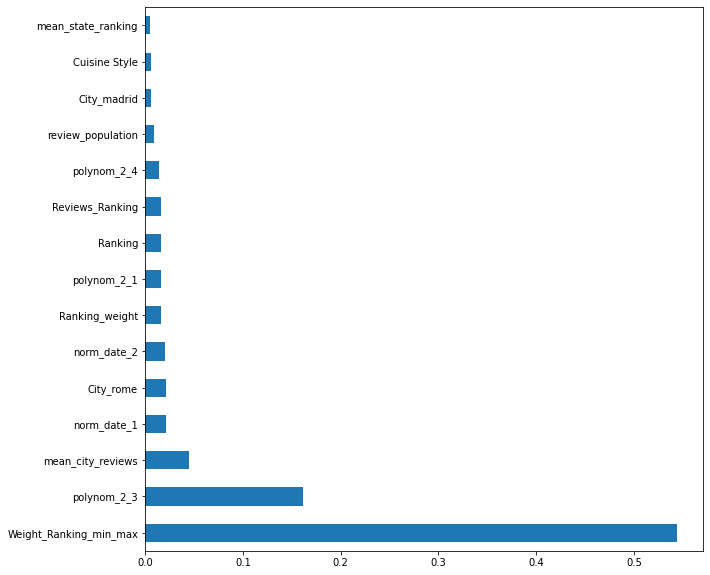

In [4546]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

# Submission
Если все устраевает - готовим Submission на кагл

In [4547]:
test_data.sample(10)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Rating,population,Price Range_isNAN,Cuisine Style_isNAN,Number of Reviews_isNAN,comment_1_isNAN,comment_2_isNAN,date_1_isNAN,date_2_isNAN,top_Cuisine,qty_rest_cuisine_city,norm_date_1,norm_date_2,Rest_count,Rest_per_capita,Ranking_weight,Weight_Ranking_min_max,review_population,mean_city_ranking,mean_state_ranking,mean_city_reviews,mean_state_reviews,Reviews_Ranking,Cuisine Style regional,american,asian,austrian,balti,bangladeshi,bar,barbecue,belgian,british,cafe,central european,chinese,...,vegan options,vegetarian friendly,vietnamese,wine bar,City_amsterdam,City_athens,City_barcelona,City_berlin,City_bratislava,City_brussels,City_budapest,City_copenhagen,City_dublin,City_edinburgh,City_geneva,City_hamburg,City_helsinki,City_krakow,City_lisbon,City_ljubljana,City_london,City_luxembourg,City_lyon,City_madrid,City_milan,City_munich,City_oporto,City_oslo,City_paris,City_prague,City_rome,City_stockholm,City_vienna,City_warsaw,City_zurich,polynom_2_0,polynom_2_1,polynom_2_2,polynom_2_3,polynom_2_4
2648,4,2692.0,2.000000,451.0,0.0,2140526,0,0,0,0,0,0,0,1,57,0.598627,0.619356,6108,0.002854,0.440733,0.808,0.000211,6938.557138,6061.501382,111.464800,107.102433,0.167533,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.168867,-1.070431,0.104217,1.224168,-0.992925
1033,6,3476.0,2.000000,346.0,0.0,2856133,0,0,0,0,0,0,0,0,54,0.673365,0.657326,2589,0.000906,1.342603,0.416,0.000121,2970.733102,3039.724967,281.280417,219.493659,0.099540,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.801953,0.279784,0.023414,3.513981,0.012970
2267,5,413.0,2.000000,359.0,0.0,1921153,0,0,0,0,0,0,0,0,56,0.692742,0.786421,1443,0.000751,0.286209,0.880,0.000187,1711.275814,1711.275814,73.949411,73.949411,0.869249,0,1,0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.847380,-1.301773,0.032263,0.396867,-1.063179
3616,5,869.0,2.000000,55.0,0.0,1899160,0,0,0,0,0,0,0,0,49,0.415935,0.328260,1186,0.000624,0.732715,0.683,0.000029,1375.409781,2384.061160,41.191400,57.021843,0.063291,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.214925,-0.633297,-0.089258,-0.141186,-0.778638
7861,1,1519.0,1.815129,27.0,0.0,1899160,1,1,0,0,0,0,0,1,49,0.629076,0.730733,1186,0.000624,1.280776,0.445,0.000014,1375.409781,2384.061160,41.191400,57.021843,0.017775,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.312769,0.187220,-0.091475,-0.190454,-0.088472
2214,1,1510.0,1.815129,2.0,0.0,515695,1,1,0,1,1,1,1,1,48,-1.009623,0.558606,1126,0.002183,1.341030,0.434,0.000004,1303.902309,6061.501382,83.438721,107.102433,0.001325,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.400129,0.277429,-0.092175,-0.465288,0.010329
8243,1,4150.0,1.815129,0.0,0.0,1620343,1,1,1,0,1,0,1,1,54,0.224938,-0.699438,3395,0.002095,1.222386,0.468,0.000000,3879.422680,4148.730993,126.491016,109.131798,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.407118,0.099803,-0.092179,-0.488396,-0.179884
4017,1,1104.0,1.815129,0.0,0.0,974073,1,0,1,0,1,0,1,0,53,-5.654448,0.158664,1033,0.001060,1.068732,0.552,0.000000,1237.482091,1237.482091,69.301065,69.301065,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.407118,-0.130236,-0.092179,-0.488396,-0.400058
3419,1,12357.0,1.815129,0.0,0.0,8961989,1,0,1,0,1,0,1,0,60,0.479600,-0.494405,7193,0.000803,1.717920,0.249,0.000000,8169.707354,8169.707354,129.816488,129.816488,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.407118,0.841682,-0.092179,-0.488396,0.731374
3346,1,2513.0,1.815129,7.0,0.0,1208542,1,0,0,1,1,1,1,0,53,-0.170897,0.776296,1314,0.

In [4548]:
test_data = test_data.drop(['Rating'], axis=1)

In [4549]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [4550]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


In [4551]:
predict_submission

array([3.015, 4.225, 4.465, ..., 3.035, 4.435, 4.39 ])

In [4552]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.015
1,id_1,4.225
2,id_2,4.465
3,id_3,4.435
4,id_4,4.420
5,id_5,4.375
6,id_6,1.970
7,id_7,3.285
8,id_8,4.120
9,id_9,4.825


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
